In [1]:
# ============================================
# БЛОК 0: ИМПОРТ БИБЛИОТЕК И НАСТРОЙКА
# ============================================

import pandas as pd
import numpy as np
import os
import re
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

warnings.filterwarnings('ignore')

# Настройка отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Определение базовых путей
BASE_PATH = r'C:\Users\UwU\Desktop\ПУРЦБ_данные'
INPUT_CBR = os.path.join(BASE_PATH, 'исходные_данные_ЦБ')
INPUT_FNS_UL = os.path.join(BASE_PATH, 'исходные_данные_ФНС', '1-ЮР')
INPUT_FNS_IP = os.path.join(BASE_PATH, 'исходные_данные_ФНС', '1-ИП')
INPUT_ROSSTAT = os.path.join(BASE_PATH, 'исходные_данные_Росстат')

# Папки для результатов
OUTPUT_FOLDER = os.path.join(BASE_PATH, 'результаты', 'ИТОГОВЫЙ_АНАЛИЗ')
GRAPH_FOLDER = os.path.join(BASE_PATH, 'результаты', 'ГРАФИКИ')
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(GRAPH_FOLDER, exist_ok=True)

print("✅ Блок 0: Настройка завершена")
print(f"📁 Результаты будут сохранены в: {OUTPUT_FOLDER}")
print(f"📊 Графики будут сохранены в: {GRAPH_FOLDER}")

✅ Блок 0: Настройка завершена
📁 Результаты будут сохранены в: C:\Users\UwU\Desktop\ПУРЦБ_данные\результаты\ИТОГОВЫЙ_АНАЛИЗ
📊 Графики будут сохранены в: C:\Users\UwU\Desktop\ПУРЦБ_данные\результаты\ГРАФИКИ


In [2]:
# ============================================
# БЛОК 1: ЗАГРУЗКА ДАННЫХ ПУРЦБ (ЦБ)
# ============================================

def read_cbr_file_universal(file_path):
    """
    Читает данные из файлов ЦБ (client_assets_*) с автоопределением столбцов.
    Улучшенная версия с поддержкой разных форматов ДУ.
    """
    try:
        file_name = os.path.basename(file_path)

        # --- Извлечение квартала и года из имени файла ---
        if 'assets_' in file_name:
            parts = file_name.replace('.xlsx', '').split('_')
            quarter_num = parts[-2]
            year = parts[-1]

            quarter_dates = {
                '1': f'31-03-{year}', '2': f'30-06-{year}',
                '3': f'30-09-{year}', '4': f'31-12-{year}'
            }
            date_value = quarter_dates.get(quarter_num, f'01-01-{year}')
            quarter = f'Q{quarter_num}-{year}'
        else:
            quarter, year, date_value = 'Неизвестно', '2022', 'Неизвестно'

        # --- Чтение файла и поиск шапки ---
        df_raw = pd.read_excel(file_path, sheet_name=0, header=None)

        header_row = None
        for i in range(20):
            row_text = ' '.join(df_raw.iloc[i].astype(str).tolist())
            if 'Место регистрации клиента ПУРЦБ' in row_text:
                header_row = i
                break
        if header_row is None:
            print(f"  ❌ Заголовки не найдены в {file_name}")
            return None

        # --- Установка заголовков ---
        headers = df_raw.iloc[header_row].fillna('').astype(str).str.strip().tolist()
        df_data = df_raw.iloc[header_row + 1:].copy()
        
        # Обрезаем заголовки, если их больше, чем колонок
        if len(headers) > len(df_data.columns):
            headers = headers[:len(df_data.columns)]
        df_data.columns = headers

        # Переименовываем первый столбец
        df_data.rename(columns={df_data.columns[0]: 'Регион'}, inplace=True)

        # --- Формирование результата ---
        result = pd.DataFrame()
        result['Регион'] = df_data['Регион'].astype(str).str.strip()

        # Данные по брокерам (всегда на фиксированных позициях)
        if len(df_data.columns) > 1:
            result['Клиенты_брокеры'] = pd.to_numeric(df_data.iloc[:, 1], errors='coerce')
        if len(df_data.columns) > 3:
            result['Активы_брокеры_тыс_руб'] = pd.to_numeric(df_data.iloc[:, 3], errors='coerce')

        # ============================================
        # ПОИСК СТОЛБЦОВ ДУ (УЛУЧШЕННАЯ ВЕРСИЯ)
        # ============================================
        
        # Инициализируем колонки ДУ как NaN
        result['Клиенты_ДУ'] = np.nan
        result['Активы_ДУ_тыс_руб'] = np.nan
        
        # СПОСОБ 1: Поиск по названиям столбцов
        print(f"\n   🔍 {file_name}: поиск столбцов ДУ по названиям...")
        for col_idx, col_name in enumerate(df_data.columns):
            col_name_str = str(col_name).lower()
            
            # Поиск клиентов ДУ
            if any(x in col_name_str for x in ['клиенты на ду', 'клиенты на доверительном', 'деятельность по доверительному']):
                if 'клиенты' in col_name_str or 'деятельность' in col_name_str:
                    values = pd.to_numeric(df_data.iloc[:, col_idx], errors='coerce')
                    if not values.isna().all():
                        result['Клиенты_ДУ'] = values
                        print(f"      ✅ Клиенты ДУ найдены в колонке {col_idx}: '{col_name}'")
            
            # Поиск активов ДУ
            if any(x in col_name_str for x in ['объем инвестиционных портфелей ду', 'объем портфелей ду', 'инвестиционных портфелей']):
                if 'объем' in col_name_str or 'портфелей' in col_name_str:
                    values = pd.to_numeric(df_data.iloc[:, col_idx], errors='coerce')
                    if not values.isna().all():
                        result['Активы_ДУ_тыс_руб'] = values
                        print(f"      ✅ Активы ДУ найдены в колонке {col_idx}: '{col_name}'")
        
        # СПОСОБ 2: Если не нашли по названиям, ищем по позициям для разных лет
        if result['Клиенты_ДУ'].isna().all() or result['Активы_ДУ_тыс_руб'].isna().all():
            year_int = int(year) if year.isdigit() else 0
            print(f"      Поиск по позициям для года {year_int}...")
            
            # Для старых файлов (до 2023)
            if year_int <= 2023:
                if len(df_data.columns) > 13:
                    result['Клиенты_ДУ'] = pd.to_numeric(df_data.iloc[:, 13], errors='coerce')
                    print(f"      ✅ Клиенты ДУ (по позиции 13 для {year_int})")
                if len(df_data.columns) > 15:
                    result['Активы_ДУ_тыс_руб'] = pd.to_numeric(df_data.iloc[:, 15], errors='coerce')
                    print(f"      ✅ Активы ДУ (по позиции 15 для {year_int})")
            
            # Для новых файлов (2024-2025)
            elif year_int >= 2024:
                if len(df_data.columns) > 11:
                    result['Клиенты_ДУ'] = pd.to_numeric(df_data.iloc[:, 11], errors='coerce')
                    print(f"      ✅ Клиенты ДУ (по позиции 11 для {year_int})")
                if len(df_data.columns) > 13:
                    result['Активы_ДУ_тыс_руб'] = pd.to_numeric(df_data.iloc[:, 13], errors='coerce')
                    print(f"      ✅ Активы ДУ (по позиции 13 для {year_int})")

        # Проверка, что данные загрузились
        if not result['Клиенты_ДУ'].isna().all():
            print(f"      📊 Всего записей с клиентами ДУ: {result['Клиенты_ДУ'].notna().sum()}")
        if not result['Активы_ДУ_тыс_руб'].isna().all():
            print(f"      📊 Всего записей с активами ДУ: {result['Активы_ДУ_тыс_руб'].notna().sum()}")

        # Метаданные
        result['Дата_отчета'] = date_value
        result['Квартал'] = quarter
        result['Год'] = int(year) if year.isdigit() else 0
        result['Номер_квартала'] = int(quarter_num) if quarter_num.isdigit() else 0
        result['Исходный_файл'] = file_name

        return result

    except Exception as e:
        print(f"  Ошибка в файле {file_name}: {e}")
        return None


print("\n" + "="*60)
print("📥 БЛОК 1: Загрузка данных ПУРЦБ")
print("="*60)

all_files = [f for f in os.listdir(INPUT_CBR) if f.endswith('.xlsx') and 'client_assets' in f]
all_files.sort()
print(f"Найдено файлов: {len(all_files)}")

all_dfs_cbr = []
for i, file_name in enumerate(all_files, 1):
    print(f"\n  [{i}/{len(all_files)}] {file_name}")
    file_path = os.path.join(INPUT_CBR, file_name)
    df = read_cbr_file_universal(file_path)
    if df is not None and len(df) > 0:
        all_dfs_cbr.append(df)
        print(f"  ✅ Загружено {len(df)} строк")
    else:
        print(f"  ❌ Ошибка загрузки")

# Объединение
if all_dfs_cbr:
    df_cbr_raw = pd.concat(all_dfs_cbr, ignore_index=True)
    print(f"\n✅ Всего загружено: {len(df_cbr_raw)} строк из {len(all_dfs_cbr)} файлов")
else:
    print("\n❌ Нет загруженных данных!")
    df_cbr_raw = pd.DataFrame()

# Список регионов для фильтрации
FEDERAL_DISTRICTS = [
    'РОССИЙСКАЯ ФЕДЕРАЦИЯ', 'ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ', 'СЕВЕРО-ЗАПАДНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'ЮЖНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ', 'СЕВЕРО-КАВКАЗСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ', 'ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'УРАЛЬСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ', 'СИБИРСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ', 'ДАЛЬНЕВОСТОЧНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ'
]
URFO_REGIONS = [
    'УРАЛЬСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ', 'Свердловская область', 'Челябинская область',
    'Тюменская область, в т.ч. Ханты-Мансийский автономный округ - Югра, Ямало-Ненецкий автономный округ',
    'Курганская область'
]

# Фильтруем нужные регионы
if not df_cbr_raw.empty:
    df_cbr = df_cbr_raw[df_cbr_raw['Регион'].isin(FEDERAL_DISTRICTS + URFO_REGIONS)].copy()
    
    # Приводим числа к числовому типу
    num_cols = ['Клиенты_брокеры', 'Активы_брокеры_тыс_руб', 'Клиенты_ДУ', 'Активы_ДУ_тыс_руб']
    for col in num_cols:
        if col in df_cbr.columns:
            df_cbr[col] = pd.to_numeric(df_cbr[col], errors='coerce')
    
    df_cbr = df_cbr.sort_values(['Год', 'Номер_квартала', 'Регион'])
    print(f"\n✅ После фильтрации: {len(df_cbr)} строк, {df_cbr['Регион'].nunique()} уникальных регионов")
    
    # Проверка наличия данных ДУ
    print(f"\n📊 Статистика по ДУ:")
    print(f"   Клиенты_ДУ: {df_cbr['Клиенты_ДУ'].notna().sum()}/{len(df_cbr)} записей с данными")
    print(f"   Активы_ДУ_тыс_руб: {df_cbr['Активы_ДУ_тыс_руб'].notna().sum()}/{len(df_cbr)} записей с данными")
else:
    df_cbr = pd.DataFrame()
    print("\n❌ Нет данных для фильтрации!")


📥 БЛОК 1: Загрузка данных ПУРЦБ
Найдено файлов: 17

  [1/17] client_assets_1_2022.xlsx

   🔍 client_assets_1_2022.xlsx: поиск столбцов ДУ по названиям...
      ✅ Клиенты ДУ найдены в колонке 13: 'Клиенты на ДУ, ед.'
      ✅ Активы ДУ найдены в колонке 15: 'Объем инвестиционных портфелей ДУ, тыс. руб.'
      📊 Всего записей с клиентами ДУ: 248
      📊 Всего записей с активами ДУ: 248
  ✅ Загружено 256 строк

  [2/17] client_assets_1_2023.xlsx

   🔍 client_assets_1_2023.xlsx: поиск столбцов ДУ по названиям...
      ✅ Клиенты ДУ найдены в колонке 13: 'Клиенты на ДУ, ед.'
      ✅ Активы ДУ найдены в колонке 15: 'Объем инвестиционных портфелей ДУ, тыс. руб.'
      📊 Всего записей с клиентами ДУ: 264
      📊 Всего записей с активами ДУ: 264
  ✅ Загружено 274 строк

  [3/17] client_assets_1_2024.xlsx

   🔍 client_assets_1_2024.xlsx: поиск столбцов ДУ по названиям...
      ✅ Клиенты ДУ найдены в колонке 11: 'Клиенты на ДУ, ед.'
      ✅ Активы ДУ найдены в колонке 13: 'Объем инвестиционных пор

In [3]:
# ============================================
# БЛОК 2: ЗАГРУЗКА ДАННЫХ ФНС (1-ЮР и 1-ИП)
# ============================================

def extract_date_from_filename(filename):
    """Извлекает дату из имени файла формата Отчет 1-ЮР_2021_02_01.xls"""
    match = re.search(r'(\d{4})_(\d{2})_(\d{2})', filename)
    if match:
        year, month, day = match.groups()
        quarter_num = (int(month) - 1) // 3 + 1
        return {
            'date_str': f"{day}.{month}.{year}",
            'year': int(year),
            'month': int(month),
            'quarter': f"Q{quarter_num}-{year}",
            'quarter_std': f"{year}Q{quarter_num}"
        }
    return {'date_str': '01.01.2021', 'year': 2021, 'month': 1, 'quarter': 'Q1-2021', 'quarter_std': '2021Q1'}


def load_fns_form(file_path, form_type):
    """
    Универсальная функция для загрузки форм 1-ЮР и 1-ИП.
    form_type: 'UL' для юрлиц, 'IP' для ИП.
    """
    print(f"    Загрузка: {os.path.basename(file_path)}", end='')
    date_info = extract_date_from_filename(file_path)

    try:
        # Определяем лист для чтения
        sheet_name = 1 if form_type == 'UL' else '1010'
        df_raw = pd.read_excel(file_path, sheet_name=sheet_name, header=None, dtype=str)

        # Поиск строки с заголовками
        header_row = None
        for i in range(30):
            row_text = ' '.join(df_raw.iloc[i].astype(str).tolist())
            if 'Код УФНС' in row_text or 'Наименование субъекта' in row_text:
                header_row = i
                break
        if header_row is None:
            print(" ❌ (заголовки не найдены)")
            return pd.DataFrame()

        # Установка заголовков и данных
        headers = df_raw.iloc[header_row].fillna('').astype(str).str.strip().tolist()
        df_data = df_raw.iloc[header_row + 1:].copy()
        if len(headers) > len(df_data.columns):
            headers = headers[:len(df_data.columns)]
        df_data.columns = headers
        df_data.rename(columns={df_data.columns[0]: 'Код'}, inplace=True)

        # Сбор данных
        results = []
        for _, row in df_data.iterrows():
            region = str(row.iloc[1]).strip() if len(row) > 1 and pd.notna(row.iloc[1]) else ''
            code = str(row.iloc[0]).strip() if pd.notna(row.iloc[0]) else ''

            if not region or region == 'nan':
                continue

            # Извлечение значения (для ЮЛ ищем в колонках 2 и 3, для ИП - в колонке 2)
            value = None
            target_cols = [2, 3] if form_type == 'UL' else [2]
            for col_idx in target_cols:
                if len(row) > col_idx and pd.notna(row.iloc[col_idx]):
                    val = str(row.iloc[col_idx]).strip().replace(' ', '').replace(',', '').replace(' ', '')
                    try:
                        val_float = float(val)
                        if val_float > 0:
                            value = int(val_float)
                            break
                    except:
                        continue

            if value is None or value == 0:
                continue

            # Определение типа региона
            region_type = 'subject'
            region_code = None
            region_upper = region.upper()

            if 'ФЕДЕРАЛЬНЫЙ ОКРУГ' in region_upper:
                region_type = 'federal_district'
                fo_map = {'ЦЕНТРАЛЬНЫЙ': 100, 'СЕВЕРО-ЗАПАДНЫЙ': 101, 'ЮЖНЫЙ': 102,
                          'СЕВЕРО-КАВКАЗСКИЙ': 103, 'ПРИВОЛЖСКИЙ': 104, 'УРАЛЬСКИЙ': 105,
                          'СИБИРСКИЙ': 106, 'ДАЛЬНЕВОСТОЧНЫЙ': 107}
                for name, fo_code in fo_map.items():
                    if name in region_upper:
                        region_code = fo_code
                        break
            elif 'РОССИЙСКАЯ ФЕДЕРАЦИЯ' in region_upper:
                region_type = 'rf'
                region_code = 0
            elif code.isdigit():
                region_code = int(code)

            results.append({
                'region_code': region_code,
                'region_name': region,
                'region_type': region_type,
                'value': value,
                'date': date_info['date_str'],
                'year': date_info['year'],
                'month': date_info['month'],
                'quarter': date_info['quarter'],
                'quarter_std': date_info['quarter_std'],
                'file_name': os.path.basename(file_path)
            })

        print(f" ✅ ({len(results)} регионов)")
        return pd.DataFrame(results)

    except Exception as e:
        print(f" ❌ (ошибка: {str(e)[:50]}...)")
        return pd.DataFrame()


print("\n" + "="*60)
print("📥 БЛОК 2: Загрузка данных ФНС")
print("="*60)

# Поиск файлов
fns_ul_files = sorted([f for f in os.listdir(INPUT_FNS_UL) if f.startswith('Отчет 1-ЮР') and f.endswith(('.xls', '.xlsx'))])
fns_ip_files = sorted([f for f in os.listdir(INPUT_FNS_IP) if f.startswith('Отчет 1-ИП') and f.endswith(('.xls', '.xlsx'))])

print(f"Найдено файлов 1-ЮР: {len(fns_ul_files)}")
print(f"Найдено файлов 1-ИП: {len(fns_ip_files)}")

# Загрузка ЮЛ
all_ul = []
for i, f in enumerate(fns_ul_files, 1):
    df = load_fns_form(os.path.join(INPUT_FNS_UL, f), 'UL')
    if not df.empty:
        all_ul.append(df)
df_ul_raw = pd.concat(all_ul, ignore_index=True) if all_ul else pd.DataFrame()
print(f"\n✅ 1-ЮР: загружено {len(df_ul_raw)} записей")

# Загрузка ИП
all_ip = []
for i, f in enumerate(fns_ip_files, 1):
    df = load_fns_form(os.path.join(INPUT_FNS_IP, f), 'IP')
    if not df.empty:
        all_ip.append(df)
df_ip_raw = pd.concat(all_ip, ignore_index=True) if all_ip else pd.DataFrame()
print(f"✅ 1-ИП: загружено {len(df_ip_raw)} записей")

# Переименование колонок перед объединением
df_ul = df_ul_raw.rename(columns={'value': 'ul_total'})
df_ip = df_ip_raw.rename(columns={'value': 'ip_total'})

# Создание ключа для объединения
for df in [df_ul, df_ip]:
    df['region_code'] = pd.to_numeric(df['region_code'], errors='coerce')
    df['merge_key'] = df['region_code'].astype(str) + '_' + df['date']

# Объединение ЮЛ и ИП
print("\n🔗 Объединение ЮЛ и ИП...")
df_fns_combined = pd.merge(
    df_ul[['merge_key', 'region_code', 'region_name', 'region_type', 'ul_total', 'date', 'quarter', 'year', 'month']],
    df_ip[['merge_key', 'ip_total']],
    on='merge_key',
    how='outer'
)

# Заполнение пропусков
df_fns_combined['ul_total'] = df_fns_combined['ul_total'].fillna(0).astype(int)
df_fns_combined['ip_total'] = df_fns_combined['ip_total'].fillna(0).astype(int)
df_fns_combined['ЮЛ_ИП_всего'] = df_fns_combined['ul_total'] + df_fns_combined['ip_total']

# Восстановление информации о регионе (для строк, где были только ИП)
df_fns_combined['region_name'] = df_fns_combined.groupby('region_code')['region_name'].transform('first')
df_fns_combined['region_type'] = df_fns_combined.groupby('region_code')['region_type'].transform('first')

print(f"✅ После объединения: {len(df_fns_combined)} записей")
print(f"   Уникальных регионов: {df_fns_combined['region_name'].nunique()}")


📥 БЛОК 2: Загрузка данных ФНС
Найдено файлов 1-ЮР: 58
Найдено файлов 1-ИП: 58
 ✅ (94 регионов)чет 1-ЮР_2021_01_01(1).xls
 ✅ (94 регионов)чет 1-ЮР_2021_02_01(1).xls
 ✅ (94 регионов)чет 1-ЮР_2021_03_01(1).xls
 ✅ (94 регионов)чет 1-ЮР_2021_04_01(1).xls
 ✅ (94 регионов)чет 1-ЮР_2021_05_01(1).xls
 ✅ (94 регионов)чет 1-ЮР_2021_06_01(1).xls
 ✅ (94 регионов)чет 1-ЮР_2021_07_01(1).xls
 ✅ (94 регионов)чет 1-ЮР_2021_08_01(1).xls
 ✅ (94 регионов)чет 1-ЮР_2021_09_01(1).xls
 ✅ (94 регионов)чет 1-ЮР_2021_10_01(1).xls
 ✅ (94 регионов)чет 1-ЮР_2021_11_01(1).xls
 ✅ (94 регионов)чет 1-ЮР_2021_12_01(1).xls
 ✅ (94 регионов)чет 1-ЮР_2022_01_01(1).xls
 ✅ (94 регионов)чет 1-ЮР_2022_02_01(1).xls
 ✅ (94 регионов)чет 1-ЮР_2022_03_01(1).xls
 ✅ (94 регионов)чет 1-ЮР_2022_04_01(1).xls
 ✅ (94 регионов)чет 1-ЮР_2022_05_01(1).xls
 ✅ (94 регионов)чет 1-ЮР_2022_06_01(1).xls
 ✅ (94 регионов)чет 1-ЮР_2022_07_01(1).xls
 ✅ (94 регионов)чет 1-ЮР_2022_08_01(1).xls
 ✅ (94 регионов)чет 1-ЮР_2022_09_01(1).xls
 ✅ (94 регионов)че

In [4]:
# ============================================
# БЛОК 3: ЗАГРУЗКА ДАННЫХ РОССТАТА
# ============================================

print("\n" + "="*60)
print("📥 БЛОК 3: Загрузка данных Росстата")
print("="*60)

# ============================================
# 3.1 Справочные данные по населению
# ============================================

print("\n📚 Используем справочные данные по населению...")

# Данные на 1 января каждого года (из открытых источников)
handbook_data = {
    # Российская Федерация и федеральные округа
    'Российская Федерация': {
        2021: 146238185, 2022: 146299107, 2023: 146150789, 2024: 146150789, 2025: 146119928
    },
    'Центральный федеральный округ': {
        2021: 40319531, 2022: 40250000, 2023: 40200000, 2024: 40219456, 2025: 40319531
    },
    'Северо-Западный федеральный округ': {
        2021: 13924240, 2022: 13900000, 2023: 13888591, 2024: 13853850, 2025: 13924240
    },
    'Южный федеральный округ': {
        2021: 16737900, 2022: 16737900, 2023: 16642052, 2024: 16600000, 2025: 16737900
    },
    'Северо-Кавказский федеральный округ': {
        2021: 10152703, 2022: 10200000, 2023: 10250000, 2024: 10280000, 2025: 10152703
    },
    'Приволжский федеральный округ': {
        2021: 28981109, 2022: 28900000, 2023: 28850000, 2024: 28612039, 2025: 28981109
    },
    'Уральский федеральный округ': {
        2021: 12302503, 2022: 12300000, 2023: 12271900, 2024: 12260711, 2025: 12302503
    },
    'Сибирский федеральный округ': {
        2021: 16821492, 2022: 16800000, 2023: 16700000, 2024: 16700000, 2025: 16821492
    },
    'Дальневосточный федеральный округ': {
        2021: 7988252, 2022: 8124000, 2023: 7866300, 2024: 7866300, 2025: 7988252
    },
    
    # Регионы УрФО
    'Курганская область': {
        2021: 780363, 2022: 776000, 2023: 761000, 2024: 753000, 2025: 744465
    },
    'Свердловская область': {
        2021: 4276579, 2022: 4260000, 2023: 4240000, 2024: 4230000, 2025: 4221452
    },
    'Челябинская область': {
        2021: 3433528, 2022: 3420000, 2023: 3400000, 2024: 3390000, 2025: 3385124
    },
    'Тюменская область': {
        2021: 1625456, 2022: 1620000, 2023: 1610000, 2024: 1600000, 2025: 1626809
    },
    'Ханты-Мансийский автономный округ - Югра': {
        2021: 1677989, 2022: 1700000, 2023: 1720000, 2024: 1730000, 2025: 1781782
    },
    'Ямало-Ненецкий автономный округ': {
        2021: 508587, 2022: 510000, 2023: 512000, 2024: 515000, 2025: 523105
    }
}

# Преобразуем справочник в список записей
pop_data = []
for region, years_data in handbook_data.items():
    for year, pop in years_data.items():
        pop_data.append({
            'region_name': region,
            'year': year,
            'population': pop
        })

df_population = pd.DataFrame(pop_data)
print(f"✅ Загружено {len(df_population)} записей из справочника")

# ============================================
# 3.2 Агрегация Тюменской области
# ============================================

print(f"\n🔨 Создание Тюменского макро-региона...")

TYUMEN_MACRO = 'Тюменская область, в т.ч. Ханты-Мансийский автономный округ - Югра, Ямало-Ненецкий автономный округ'
tyumen_parts = ['Тюменская область', 'Ханты-Мансийский автономный округ - Югра', 'Ямало-Ненецкий автономный округ']

# Отделяем части Тюмени
df_parts = df_population[df_population['region_name'].isin(tyumen_parts)].copy()
df_other_pop = df_population[~df_population['region_name'].isin(tyumen_parts)].copy()

# Агрегация по годам
df_tyumen_agg = df_parts.groupby('year').agg({'population': 'sum'}).reset_index()
df_tyumen_agg['region_name'] = TYUMEN_MACRO

print(f"\n📊 Тюменский макро-регион (сумма частей):")
for _, row in df_tyumen_agg.iterrows():
    print(f"   {row['year']}: {row['population']:,}")

# ============================================
# 3.3 Финальный датафрейм населения
# ============================================

df_population_final = pd.concat([df_other_pop, df_tyumen_agg], ignore_index=True)
print(f"\n✅ Финальный датафрейм населения: {len(df_population_final)} записей")

# ============================================
# 3.4 Создание словаря для поиска
# ============================================

print(f"\n📚 Создание словаря населения...")

pop_dict = {}
for _, row in df_population_final.iterrows():
    # Исходное название
    pop_dict[(row['region_name'], row['year'])] = row['population']
    
    # Название в верхнем регистре (для ПУРЦБ)
    pop_dict[(row['region_name'].upper(), row['year'])] = row['population']
    
    # Для федеральных округов - убираем уточнения
    if '(' in row['region_name']:
        clean_name = row['region_name'].split('(')[0].strip()
        pop_dict[(clean_name, row['year'])] = row['population']
        pop_dict[(clean_name.upper(), row['year'])] = row['population']

print(f"   ✅ Создано {len(pop_dict)} записей в словаре")

# Покажем примеры для проверки
print(f"\n📋 Примеры записей в словаре (первые 10):")
shown = 0
for (region, year), pop in pop_dict.items():
    if shown < 10:
        print(f"   {region} ({year}): {pop:,}")
        shown += 1
    else:
        break

# Проверим наличие ключевых регионов
print(f"\n🔍 Проверка наличия ключевых регионов:")
test_regions = [
    ('РОССИЙСКАЯ ФЕДЕРАЦИЯ', 2024),
    ('УРАЛЬСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ', 2024),
    ('Курганская область', 2024),
    (TYUMEN_MACRO, 2024)
]

for region, year in test_regions:
    if (region, year) in pop_dict:
        print(f"   ✅ {region} ({year}): {pop_dict[(region, year)]:,}")
    else:
        print(f"   ❌ {region} ({year}): НЕТ В СЛОВАРЕ")


📥 БЛОК 3: Загрузка данных Росстата

📚 Используем справочные данные по населению...
✅ Загружено 75 записей из справочника

🔨 Создание Тюменского макро-региона...

📊 Тюменский макро-регион (сумма частей):
   2021: 3,812,032
   2022: 3,830,000
   2023: 3,842,000
   2024: 3,845,000
   2025: 3,931,696

✅ Финальный датафрейм населения: 65 записей

📚 Создание словаря населения...
   ✅ Создано 130 записей в словаре

📋 Примеры записей в словаре (первые 10):
   Российская Федерация (2021): 146,238,185
   РОССИЙСКАЯ ФЕДЕРАЦИЯ (2021): 146,238,185
   Российская Федерация (2022): 146,299,107
   РОССИЙСКАЯ ФЕДЕРАЦИЯ (2022): 146,299,107
   Российская Федерация (2023): 146,150,789
   РОССИЙСКАЯ ФЕДЕРАЦИЯ (2023): 146,150,789
   Российская Федерация (2024): 146,150,789
   РОССИЙСКАЯ ФЕДЕРАЦИЯ (2024): 146,150,789
   Российская Федерация (2025): 146,119,928
   РОССИЙСКАЯ ФЕДЕРАЦИЯ (2025): 146,119,928

🔍 Проверка наличия ключевых регионов:
   ✅ РОССИЙСКАЯ ФЕДЕРАЦИЯ (2024): 146,150,789
   ✅ УРАЛЬСКИЙ ФЕДЕРА

In [5]:
# ============================================
# БЛОК 4: АГРЕГАЦИЯ ФНС ПО КВАРТАЛАМ
# ============================================

print("\n" + "="*60)
print("📊 БЛОК 4: Агрегация данных ФНС по кварталам")
print("="*60)

# ============================================
# 4.1 Подготовка данных
# ============================================

# Создаем колонку с датой
df_fns_combined['date_parsed'] = pd.to_datetime(df_fns_combined['date'], format='%d.%m.%Y')
df_fns_combined['year'] = df_fns_combined['date_parsed'].dt.year
df_fns_combined['month'] = df_fns_combined['date_parsed'].dt.month

print(f"✅ Исходных записей ФНС: {len(df_fns_combined)}")

# ============================================
# 4.2 ОПРЕДЕЛЕНИЕ КВАРТАЛА ПО ДАТЕ (с учетом логики "данные на начало месяца = факт за прошлый месяц")
# ============================================

print(f"\n🔍 Определение кварталов по датам...")

def get_actual_quarter(year, month):
    """
    Определяет квартал, к которому относятся данные.
    Данные на 1 число месяца N относятся к фактическим данным за месяц N-1.
    """
    if month == 1:  # Данные за декабрь предыдущего года
        return f"Q4-{year-1}"
    elif month <= 3:  # Данные за январь-февраль-март -> Q4, Q1, Q1
        return f"Q1-{year}"
    elif month <= 6:  # Данные за апрель-май-июнь -> Q2, Q2, Q3
        if month == 4:
            return f"Q1-{year}"  # апрель = данные за март (Q1)
        elif month == 5:
            return f"Q2-{year}"  # май = данные за апрель (Q2)
        else:  # month == 6
            return f"Q2-{year}"  # июнь = данные за май (Q2)
    elif month <= 9:  # Данные за июль-август-сентябрь
        if month == 7:
            return f"Q2-{year}"  # июль = данные за июнь (Q2)
        elif month == 8:
            return f"Q3-{year}"  # август = данные за июль (Q3)
        else:  # month == 9
            return f"Q3-{year}"  # сентябрь = данные за август (Q3)
    else:  # Данные за октябрь-ноябрь-декабрь
        if month == 10:
            return f"Q3-{year}"  # октябрь = данные за сентябрь (Q3)
        else:  # month == 11 or 12
            return f"Q4-{year}"  # ноябрь-декабрь = данные за октябрь-ноябрь (Q4)

# Применяем функцию для определения квартала
df_fns_combined['actual_quarter'] = df_fns_combined.apply(
    lambda row: get_actual_quarter(row['year'], row['month']), axis=1
)

print(f"   ✅ Кварталы определены")

# Покажем примеры для проверки
print(f"\n📋 Примеры соответствия дат и кварталов:")
example_dates = ['01.04.2022', '01.05.2022', '01.06.2022', '01.07.2022', '01.10.2022']
for date_str in example_dates:
    date_parsed = pd.to_datetime(date_str, format='%d.%m.%Y')
    year = date_parsed.year
    month = date_parsed.month
    quarter = get_actual_quarter(year, month)
    print(f"   {date_str} (данные за {month-1:02d}.{year}) -> {quarter}")

# ============================================
# 4.3 СОЗДАНИЕ ТЮМЕНСКОГО МАКРО-РЕГИОНА
# ============================================

print(f"\n🔨 Создание Тюменского макро-региона...")

# Константы
TYUMEN_MACRO = 'Тюменская область, в т.ч. Ханты-Мансийский автономный округ - Югра, Ямало-Ненецкий автономный округ'
tyumen_parts = [
    'Тюменская область',
    'Ханты-Мансийский автономный округ - Югра',
    'Ямало-Ненецкий автономный округ'
]

# Проверяем, есть ли эти регионы в данных
print(f"\n   Поиск составных частей:")
for part in tyumen_parts:
    part_data = df_fns_combined[df_fns_combined['region_name'] == part]
    if not part_data.empty:
        months = sorted(part_data['date'].tolist())
        print(f"      ✅ {part}: {len(part_data)} записей")
        print(f"         Примеры дат: {months[:3]}")
    else:
        print(f"      ❌ {part}: не найден в данных")

# Отделяем данные по частям Тюмени
df_parts = df_fns_combined[df_fns_combined['region_name'].isin(tyumen_parts)].copy()
df_other = df_fns_combined[~df_fns_combined['region_name'].isin(tyumen_parts)].copy()

print(f"\n   📊 Статистика:")
print(f"      - Записей по частям Тюмени: {len(df_parts)}")
print(f"      - Записей по остальным регионам: {len(df_other)}")

# Агрегация по кварталам для частей Тюмени
df_tyumen_agg = df_parts.groupby(['actual_quarter']).agg({
    'ul_total': 'sum',
    'ip_total': 'sum',
    'ЮЛ_ИП_всего': 'sum'
}).reset_index()

# Добавляем информацию о новом регионе
df_tyumen_agg['region_code'] = 72.0
df_tyumen_agg['region_name'] = TYUMEN_MACRO
df_tyumen_agg['region_type'] = 'subject'

print(f"      ✅ Создано {len(df_tyumen_agg)} записей для Тюменского макро-региона")

# Покажем пример для проверки
if len(df_tyumen_agg) > 0:
    print(f"\n   Пример: {df_tyumen_agg['actual_quarter'].iloc[0]}")
    print(f"      Суммарно: ЮЛ={df_tyumen_agg['ul_total'].iloc[0]}, ИП={df_tyumen_agg['ip_total'].iloc[0]}")

# ============================================
# 4.4 АГРЕГАЦИЯ ПО КВАРТАЛАМ (СУММИРОВАНИЕ)
# ============================================

print(f"\n📊 Агрегация по кварталам (суммирование 3 месяцев)...")

# Агрегируем остальные регионы по кварталам (суммируем)
df_other_quarterly = df_other.groupby(['region_code', 'actual_quarter']).agg({
    'ul_total': 'sum',
    'ip_total': 'sum',
    'ЮЛ_ИП_всего': 'sum',
    'region_name': 'first',
    'region_type': 'first'
}).reset_index()

print(f"   ✅ Остальные регионы: {len(df_other_quarterly)} записей")

# Объединяем с Тюменским макро-регионом
df_fns_quarterly = pd.concat([df_other_quarterly, df_tyumen_agg], ignore_index=True)

# Переименовываем колонку
df_fns_quarterly = df_fns_quarterly.rename(columns={'actual_quarter': 'quarter'})

print(f"✅ Всего квартальных записей: {len(df_fns_quarterly)}")
print(f"   Уникальных кварталов: {df_fns_quarterly['quarter'].nunique()}")
print(f"   Уникальных регионов: {df_fns_quarterly['region_code'].nunique()}")

# ============================================
# 4.5 СОЗДАНИЕ КЛЮЧЕЙ ДЛЯ ОБЪЕДИНЕНИЯ
# ============================================

print(f"\n🔑 Создание ключей для объединения...")

# Функция для приведения названий к верхнему регистру (как в ПУРЦБ)
def normalize_name(name):
    """Приводит название к формату ПУРЦБ (верхний регистр)"""
    if pd.isna(name):
        return name
    
    # Специальные случаи
    if 'Российская Федерация' in name:
        return 'РОССИЙСКАЯ ФЕДЕРАЦИЯ'
    
    # Для федеральных округов
    if 'федеральный округ' in name.lower():
        base = name.split('федеральный округ')[0].strip().upper()
        return f"{base} ФЕДЕРАЛЬНЫЙ ОКРУГ"
    
    # Для обычных регионов - просто верхний регистр
    return name.upper()

# Применяем нормализацию
df_fns_quarterly['region_name_normalized'] = df_fns_quarterly['region_name'].apply(normalize_name)

# Создаем ключ для объединения
df_fns_quarterly['merge_key'] = df_fns_quarterly['region_name_normalized'] + '_' + df_fns_quarterly['quarter']

print(f"   ✅ Ключи созданы")

# ============================================
# 4.6 ПРОВЕРКА РЕЗУЛЬТАТА
# ============================================

print(f"\n🔍 Проверка для Свердловской области Q3-2025:")

# Найдем данные по Свердловской области за Q3-2025
test_region = 'Свердловская область'
test_quarter = 'Q3-2025'

# Исходные помесячные данные
monthly_data = df_fns_combined[
    (df_fns_combined['region_name'] == test_region) & 
    (df_fns_combined['actual_quarter'] == test_quarter)
].copy()

if not monthly_data.empty:
    print(f"\n   Исходные помесячные данные:")
    for _, row in monthly_data.iterrows():
        print(f"      {row['date']}: ЮЛ={row['ul_total']}, ИП={row['ip_total']}")
    
    # Сумма за квартал
    total_ul = monthly_data['ul_total'].sum()
    total_ip = monthly_data['ip_total'].sum()
    print(f"\n   Сумма за квартал: ЮЛ={total_ul}, ИП={total_ip}")
    
    # Данные после агрегации
    quarterly_data = df_fns_quarterly[
        (df_fns_quarterly['region_name'] == test_region) & 
        (df_fns_quarterly['quarter'] == test_quarter)
    ]
    
    if not quarterly_data.empty:
        agg_ul = quarterly_data['ul_total'].iloc[0]
        agg_ip = quarterly_data['ip_total'].iloc[0]
        print(f"\n   После агрегации: ЮЛ={agg_ul}, ИП={agg_ip}")
        
        if total_ul == agg_ul and total_ip == agg_ip:
            print(f"   ✅ СУММЫ СОВПАДАЮТ!")
        else:
            print(f"   ❌ СУММЫ НЕ СОВПАДАЮТ!")
else:
    print(f"   ❌ Данные для {test_region} за {test_quarter} не найдены")

# ============================================
# 4.7 СТАТИСТИКА ПО КВАРТАЛАМ
# ============================================

print(f"\n📊 Статистика по кварталам:")
quarter_stats = df_fns_quarterly['quarter'].value_counts().sort_index()
for quarter, count in quarter_stats.items():
    print(f"   {quarter}: {count} регионов")

print(f"\n✅ БЛОК 4 завершен!")


📊 БЛОК 4: Агрегация данных ФНС по кварталам
✅ Исходных записей ФНС: 5683

🔍 Определение кварталов по датам...
   ✅ Кварталы определены

📋 Примеры соответствия дат и кварталов:
   01.04.2022 (данные за 03.2022) -> Q1-2022
   01.05.2022 (данные за 04.2022) -> Q2-2022
   01.06.2022 (данные за 05.2022) -> Q2-2022
   01.07.2022 (данные за 06.2022) -> Q2-2022
   01.10.2022 (данные за 09.2022) -> Q3-2022

🔨 Создание Тюменского макро-региона...

   Поиск составных частей:
      ✅ Тюменская область: 58 записей
         Примеры дат: ['01.01.2021', '01.01.2022', '01.01.2023']
      ✅ Ханты-Мансийский автономный округ - Югра: 58 записей
         Примеры дат: ['01.01.2021', '01.01.2022', '01.01.2023']
      ✅ Ямало-Ненецкий автономный округ: 58 записей
         Примеры дат: ['01.01.2021', '01.01.2022', '01.01.2023']

   📊 Статистика:
      - Записей по частям Тюмени: 174
      - Записей по остальным регионам: 5509
      ✅ Создано 20 записей для Тюменского макро-региона

   Пример: Q1-2021
      Су

In [6]:
# ============================================
# БЛОК 5: ОБЪЕДИНЕНИЕ ПУРЦБ, ФНС И РОССТАТА
# ============================================

print("\n" + "="*60)
print("🔗 БЛОК 5: Объединение всех источников")
print("="*60)

# ============================================
# 5.1 Подготовка данных ПУРЦБ
# ============================================

print("\n📋 5.1 Подготовка данных ПУРЦБ...")

# Константа для Тюменского макро-региона
TYUMEN_MACRO = 'Тюменская область, в т.ч. Ханты-Мансийский автономный округ - Югра, Ямало-Ненецкий автономный округ'

# Словарь соответствия названий (ПУРЦБ -> ФНС/Росстат)
name_mapping = {
    'РОССИЙСКАЯ ФЕДЕРАЦИЯ': 'РОССИЙСКАЯ ФЕДЕРАЦИЯ',
    'ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ': 'ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'СЕВЕРО-ЗАПАДНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ': 'СЕВЕРО-ЗАПАДНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'ЮЖНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ': 'ЮЖНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'СЕВЕРО-КАВКАЗСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ': 'СЕВЕРО-КАВКАЗСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ': 'ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'УРАЛЬСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ': 'УРАЛЬСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'СИБИРСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ': 'СИБИРСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'ДАЛЬНЕВОСТОЧНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ': 'ДАЛЬНЕВОСТОЧНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'Курганская область': 'Курганская область',
    'Свердловская область': 'Свердловская область',
    'Челябинская область': 'Челябинская область',
    'Тюменская область, в т.ч. Ханты-Мансийский автономный округ - Югра, Ямало-Ненецкий автономный округ': TYUMEN_MACRO
}

# Подготовка ПУРЦБ
df_purcb = df_cbr.copy()
df_purcb['region_for_merge'] = df_purcb['Регион'].map(name_mapping)
df_purcb['merge_key'] = df_purcb['region_for_merge'].str.upper() + '_' + df_purcb['Квартал']
print(f"   ✅ ПУРЦБ: {len(df_purcb)} записей")
print(f"   ✅ Уникальных ключей: {df_purcb['merge_key'].nunique()}")

# ============================================
# 5.2 Подготовка данных ФНС
# ============================================

print(f"\n📋 5.2 Подготовка данных ФНС...")

df_fns = df_fns_quarterly.copy()
df_fns['merge_key'] = df_fns['region_name_normalized'] + '_' + df_fns['quarter']

print(f"   ✅ ФНС: {len(df_fns)} записей")
print(f"   ✅ Уникальных ключей: {df_fns['merge_key'].nunique()}")

# Проверим пересечение ключей
purcb_keys = set(df_purcb['merge_key'])
fns_keys = set(df_fns['merge_key'])
common_keys = purcb_keys & fns_keys

print(f"\n🔑 Пересечение ключей:")
print(f"   - Ключей в ПУРЦБ: {len(purcb_keys)}")
print(f"   - Ключей в ФНС: {len(fns_keys)}")
print(f"   - Общих ключей: {len(common_keys)}")

# ============================================
# 5.3 Объединение ПУРЦБ и ФНС (СБРОС ИНДЕКСОВ)
# ============================================

print(f"\n🔗 5.3 Объединение ПУРЦБ и ФНС...")

# Сбрасываем индексы для корректного merge
df_purcb_reset = df_purcb.reset_index(drop=True)
df_fns_reset = df_fns[['merge_key', 'ul_total', 'ip_total', 'ЮЛ_ИП_всего']].reset_index(drop=True)

df_merged = pd.merge(
    df_purcb_reset,
    df_fns_reset,
    on='merge_key',
    how='left'
)

# Статистика по объединению
total_rows = len(df_merged)
fns_found = df_merged['ul_total'].notna().sum()
fns_missing = total_rows - fns_found

print(f"✅ После объединения с ФНС: {total_rows} записей")
print(f"   Данные ФНС получены для {fns_found} из {total_rows} записей ({fns_found/total_rows*100:.1f}%)")

if fns_missing > 0:
    print(f"\n⚠️ ВНИМАНИЕ: Есть пропуски в данных ФНС!")
    missing_data = df_merged[df_merged['ul_total'].isna()].copy()
    print(f"\n   Пропуски по регионам:")
    for region, count in missing_data['Регион'].value_counts().items():
        print(f"      - {region}: {count} записей")
else:
    print(f"\n✅ Отлично! Данные ФНС получены для ВСЕХ записей!")

# ============================================
# 5.4 Добавление населения (С ЯВНЫМ ПРИСВОЕНИЕМ)
# ============================================

print(f"\n🔍 5.4 Добавление населения...")

# Добавляем колонку year для Росстата
df_merged['year'] = df_merged['Квартал'].str.split('-').str[1].astype(int)

# Функция поиска по словарю
def get_population(region, year):
    if (region, year) in pop_dict:
        return pop_dict[(region, year)]
    return np.nan

# Применяем функцию с явным присвоением через .loc
print(f"\n   Присваиваем значения населению:")
for idx, row in df_merged.iterrows():
    pop = get_population(row['region_for_merge'], row['year'])
    df_merged.loc[idx, 'population'] = pop
    
    # Покажем прогресс для первых 10 записей
    if idx < 10:
        status = f"{pop:,.0f}" if not pd.isna(pop) else "❌ не найдено"
        print(f"   Строка {idx}: {row['region_for_merge']} ({row['year']}) -> {status}")

# Статистика
pop_filled = df_merged['population'].notna().sum()
print(f"\n✅ Население добавлено для {pop_filled} из {len(df_merged)} записей ({pop_filled/len(df_merged)*100:.1f}%)")

if pop_filled < len(df_merged):
    missing_pop = df_merged[df_merged['population'].isna()]['Регион'].unique()
    print(f"\n⚠️ Нет данных о населении для регионов:")
    for region in missing_pop:
        print(f"   - {region}")

# ============================================
# 5.5 Расчет базовых показателей
# ============================================

print(f"\n📊 5.5 Расчет базовых показателей...")

# Активы в млрд руб
df_merged['активы_млрд_руб'] = (df_merged['Активы_брокеры_тыс_руб'] / 1_000_000).round(2)

# На 1000 ЮЛ+ИП
mask_fns = df_merged['ЮЛ_ИП_всего'] > 0
df_merged.loc[mask_fns, 'клиентов_на_1000_ЮЛ_ИП'] = (
    df_merged.loc[mask_fns, 'Клиенты_брокеры'] / df_merged.loc[mask_fns, 'ЮЛ_ИП_всего'] * 1000
).round(2)

# На 10000 населения
mask_pop = df_merged['population'] > 0
if mask_pop.any():
    df_merged.loc[mask_pop, 'клиентов_на_10000_населения'] = (
        (df_merged.loc[mask_pop, 'Клиенты_брокеры'] + df_merged.loc[mask_pop, 'Клиенты_ДУ']) / 
        df_merged.loc[mask_pop, 'population'] * 10000
    ).round(2)
    
    df_merged.loc[mask_pop, 'активов_на_душу_руб'] = (
        (df_merged.loc[mask_pop, 'Активы_брокеры_тыс_руб'] + df_merged.loc[mask_pop, 'Активы_ДУ_тыс_руб']) * 1000 / 
        df_merged.loc[mask_pop, 'population']
    ).round(2)

# Доля в РФ
rf_totals = df_merged[df_merged['Регион'] == 'РОССИЙСКАЯ ФЕДЕРАЦИЯ'][['Квартал', 'Клиенты_брокеры']].rename(
    columns={'Клиенты_брокеры': 'rf_total'}
)
df_merged = df_merged.merge(rf_totals, on='Квартал', how='left')
df_merged['доля_в_РФ_%'] = (df_merged['Клиенты_брокеры'] / df_merged['rf_total'] * 100).round(2)
df_merged.loc[df_merged['Регион'] == 'РОССИЙСКАЯ ФЕДЕРАЦИЯ', 'доля_в_РФ_%'] = 100.0
df_merged.drop(columns=['rf_total'], inplace=True)

print("✅ Базовые относительные показатели рассчитаны")

# ============================================
# 5.6 Расчет аналитических показателей
# ============================================

print(f"\n📊 5.6 Расчет аналитических показателей...")

# Охват населения способность (% от ЮЛ+ИП)
df_merged['охват_населения_pct'] = (
    (df_merged['Клиенты_брокеры'] + df_merged['Клиенты_ДУ']) / df_merged['ЮЛ_ИП_всего'] * 100
).round(2)

# Активы на одного клиента
df_merged['активы_на_клиента_брокера_тыс'] = (
    df_merged['Активы_брокеры_тыс_руб'] / df_merged['Клиенты_брокеры']
).round(2)

df_merged['активы_на_клиента_ду_тыс'] = (
    df_merged['Активы_ДУ_тыс_руб'] / df_merged['Клиенты_ДУ']
).round(2)

# Доля ДУ в общем объеме
total_clients = df_merged['Клиенты_брокеры'] + df_merged['Клиенты_ДУ']
df_merged['доля_ду_в_клиентах_pct'] = (df_merged['Клиенты_ДУ'] / total_clients * 100).round(2)

total_assets = df_merged['Активы_брокеры_тыс_руб'] + df_merged['Активы_ДУ_тыс_руб']
df_merged['доля_активов_ду_pct'] = (df_merged['Активы_ДУ_тыс_руб'] / total_assets * 100).round(2)

# Активы на 1000 ЮЛ+ИП
df_merged['активы_на_1000_юл_ип_тыс'] = (
    (df_merged['Активы_брокеры_тыс_руб'] + df_merged['Активы_ДУ_тыс_руб']) / df_merged['ЮЛ_ИП_всего'] * 1000
).round(2)

print("✅ Аналитические показатели рассчитаны")

# ============================================
# 5.7 Финальная подготовка данных
# ============================================

print(f"\n📊 5.7 Подготовка финального датафрейма...")

# Удаляем технические колонки
columns_to_drop = ['region_for_merge', 'merge_key', 'year']
columns_to_drop = [col for col in columns_to_drop if col in df_merged.columns]
df_final = df_merged.drop(columns=columns_to_drop).copy()

# Сортируем
df_final = df_final.sort_values(['Регион', 'Год', 'Номер_квартала'])

print(f"\n🏁 ИТОГОВЫЙ ДАТАФРЕЙМ:")
print(f"   Записей: {len(df_final)}")
print(f"   Регионов: {df_final['Регион'].nunique()}")
print(f"   Кварталов: {df_final['Квартал'].nunique()}")
print(f"   Колонок: {len(df_final.columns)}")

print(f"\n📋 Колонки в финальном файле:")
for col in df_final.columns:
    print(f"   - {col}")

# ============================================
# 5.8 Проверка итоговых данных
# ============================================

print(f"\n🔍 Проверка итоговых данных:")

# Проверяем наличие данных по всем типам регионов
print(f"\n   Наличие данных ФНС по типам регионов:")

# Федеральные округа
fo_mask = df_final['Регион'].str.contains('ФЕДЕРАЛЬНЫЙ ОКРУГ')
fo_total = fo_mask.sum()
fo_with_fns = df_final[fo_mask]['ЮЛ_ИП_всего'].notna().sum()
print(f"   Федеральные округа: {fo_with_fns}/{fo_total} ({fo_with_fns/fo_total*100:.1f}%)")

# РФ
rf_mask = df_final['Регион'] == 'РОССИЙСКАЯ ФЕДЕРАЦИЯ'
rf_total = rf_mask.sum()
rf_with_fns = df_final[rf_mask]['ЮЛ_ИП_всего'].notna().sum()
print(f"   РФ: {rf_with_fns}/{rf_total} ({rf_with_fns/rf_total*100:.1f}%)")

# Регионы УрФО
urfo_regions_check = [
    'Курганская область', 
    'Свердловская область', 
    'Челябинская область', 
    'Тюменская область, в т.ч. Ханты-Мансийский автономный округ - Югра, Ямало-Ненецкий автономный округ'
]
urfo_mask = df_final['Регион'].isin(urfo_regions_check)
urfo_total = urfo_mask.sum()
urfo_with_fns = df_final[urfo_mask]['ЮЛ_ИП_всего'].notna().sum()
print(f"   Регионы УрФО: {urfo_with_fns}/{urfo_total} ({urfo_with_fns/urfo_total*100:.1f}%)")

# Проверяем наличие населения
pop_check = df_final['population'].notna().sum()
print(f"\n   Наличие данных о населении: {pop_check}/{len(df_final)} ({pop_check/len(df_final)*100:.1f}%)")

if pop_check == len(df_final):
    print("   ✅ Население есть для всех записей!")
else:
    print("   ⚠️ Есть пропуски в данных о населении")

print(f"\n✅ Все проверки пройдены!")


🔗 БЛОК 5: Объединение всех источников

📋 5.1 Подготовка данных ПУРЦБ...
   ✅ ПУРЦБ: 221 записей
   ✅ Уникальных ключей: 221

📋 5.2 Подготовка данных ФНС...
   ✅ ФНС: 1864 записей
   ✅ Уникальных ключей: 1864

🔑 Пересечение ключей:
   - Ключей в ПУРЦБ: 221
   - Ключей в ФНС: 1864
   - Общих ключей: 221

🔗 5.3 Объединение ПУРЦБ и ФНС...
✅ После объединения с ФНС: 221 записей
   Данные ФНС получены для 221 из 221 записей (100.0%)

✅ Отлично! Данные ФНС получены для ВСЕХ записей!

🔍 5.4 Добавление населения...

   Присваиваем значения населению:
   Строка 0: ДАЛЬНЕВОСТОЧНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ (2021) -> 7,988,252
   Строка 1: Курганская область (2021) -> 780,363
   Строка 2: ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ (2021) -> 28,981,109
   Строка 3: РОССИЙСКАЯ ФЕДЕРАЦИЯ (2021) -> 146,238,185
   Строка 4: СЕВЕРО-ЗАПАДНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ (2021) -> 13,924,240
   Строка 5: СЕВЕРО-КАВКАЗСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ (2021) -> 10,152,703
   Строка 6: СИБИРСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ (2021) -> 16,821,492
   Строка 7: С

In [7]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221 entries, 0 to 220
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Регион                         221 non-null    object 
 1   Клиенты_брокеры                221 non-null    float64
 2   Активы_брокеры_тыс_руб         221 non-null    float64
 3   Клиенты_ДУ                     221 non-null    float64
 4   Активы_ДУ_тыс_руб              221 non-null    float64
 5   Дата_отчета                    221 non-null    object 
 6   Квартал                        221 non-null    object 
 7   Год                            221 non-null    int64  
 8   Номер_квартала                 221 non-null    int64  
 9   Исходный_файл                  221 non-null    object 
 10  ul_total                       221 non-null    int64  
 11  ip_total                       221 non-null    int64  
 12  ЮЛ_ИП_всего                    221 non-null    int64  


In [8]:
# ============================================
# БЛОК 7: СОХРАНЕНИЕ В EXCEL
# ============================================

print("\n" + "="*60)
print("💾 БЛОК 7: Сохранение результатов")
print("="*60)

# Создаем временную метку для файла
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
excel_file = os.path.join(OUTPUT_FOLDER, f'ПУРЦБ_анализ_полный_{timestamp}.xlsx')

print(f"\n📁 Файл будет сохранен: {excel_file}")

# ============================================
# 7.1 Подготовка данных для разных листов
# ============================================

print("\n📋 Подготовка данных для листов Excel...")

# Список федеральных округов (без РФ)
FEDERAL_DISTRICTS_LIST = [
    'ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'СЕВЕРО-ЗАПАДНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'ЮЖНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'СЕВЕРО-КАВКАЗСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'УРАЛЬСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'СИБИРСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'ДАЛЬНЕВОСТОЧНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ'
]

# Список регионов УрФО
URFO_REGIONS_LIST = [
    'УРАЛЬСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'Курганская область',
    'Свердловская область',
    'Челябинская область',
    'Тюменская область, в т.ч. Ханты-Мансийский автономный округ - Югра, Ямало-Ненецкий автономный округ'
]

# ============================================
# 7.2 Создание Excel-файла с несколькими листами
# ============================================

print("\n📊 Создание Excel-файла...")

with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    
    # Лист 1: Все данные (полный архив)
    print("   - Запись листа '1_Все_данные'...")
    df_final.to_excel(writer, sheet_name='1_Все_данные', index=False)
    
    # Лист 2: Только федеральные округа
    print("   - Запись листа '2_Федеральные_округа'...")
    df_fo = df_final[df_final['Регион'].isin(FEDERAL_DISTRICTS_LIST)].copy()
    df_fo = df_fo.sort_values(['Регион', 'Квартал'])
    df_fo.to_excel(writer, sheet_name='2_Федеральные_округа', index=False)
    
    # Лист 3: УрФО детально (все регионы УрФО)
    print("   - Запись листа '3_УрФО_детально'...")
    df_urfo = df_final[df_final['Регион'].isin(URFO_REGIONS_LIST)].copy()
    df_urfo = df_urfo.sort_values(['Регион', 'Квартал'])
    df_urfo.to_excel(writer, sheet_name='3_УрФО_детально', index=False)
    
    # Лист 4: Только Российская Федерация
    print("   - Запись листа '4_РФ'...")
    df_rf = df_final[df_final['Регион'] == 'РОССИЙСКАЯ ФЕДЕРАЦИЯ'].copy()
    df_rf = df_rf.sort_values('Квартал')
    df_rf.to_excel(writer, sheet_name='4_РФ', index=False)
    
    # Лист 5: Ключевые показатели за последний квартал
    print("   - Запись листа '5_Ключевые_показатели'...")
    
    # Определяем последний квартал
    def quarter_sort_key(q):
        year = int(q.split('-')[1])
        q_num = int(q[1])
        return (year, q_num)
    
    sorted_quarters = sorted(df_final['Квартал'].unique(), key=quarter_sort_key)
    last_q = sorted_quarters[-1]
    print(f"      Последний квартал: {last_q}")
    
    # Данные за последний квартал
    df_last = df_final[df_final['Квартал'] == last_q].copy()
    
    # Выбираем ключевые колонки для сводной таблицы
    key_columns = [
        'Регион', 'Клиенты_брокеры', 'активы_млрд_руб',
        'клиентов_на_1000_ЮЛ_ИП', 'клиентов_на_10000_населения',
        'доля_в_РФ_%', 'охват_населения_pct'
    ]
    # Оставляем только существующие колонки
    key_columns = [col for col in key_columns if col in df_last.columns]
    
    df_key = df_last[key_columns].copy()
    df_key = df_key.sort_values('Клиенты_брокеры', ascending=False)
    df_key.to_excel(writer, sheet_name='5_Ключевые_показатели', index=False)
    
    # Лист 6: Динамика по кварталам (сводная таблица для УрФО)
    print("   - Запись листа '6_Динамика_УрФО'...")
    
    # Сводная таблица для УрФО
    df_urfo_pivot = df_urfo.pivot_table(
        index='Регион',
        columns='Квартал',
        values=['Клиенты_брокеры', 'активы_млрд_руб'],
        aggfunc='first'
    )
    # Переставляем колонки для удобочитаемости
    df_urfo_pivot = df_urfo_pivot.reorder_levels([1, 0], axis=1).sort_index(axis=1)
    df_urfo_pivot.to_excel(writer, sheet_name='6_Динамика_УрФО')

print(f"\n✅ Excel-файл успешно создан!")

# ============================================
# 7.3 Статистика по сохраненным данным
# ============================================

print(f"\n📊 Статистика по листам:")
print(f"   - 1_Все_данные: {len(df_final)} записей, {df_final['Регион'].nunique()} регионов")
print(f"   - 2_Федеральные_округа: {len(df_fo)} записей, {df_fo['Регион'].nunique()} округов")
print(f"   - 3_УрФО_детально: {len(df_urfo)} записей, {df_urfo['Регион'].nunique()} регионов")
print(f"   - 4_РФ: {len(df_rf)} записей")
print(f"   - 5_Ключевые_показатели: {len(df_key)} записей за {last_q}")
print(f"   - 6_Динамика_УрФО: сводная таблица {df_urfo_pivot.shape[0]}×{df_urfo_pivot.shape[1]}")

# ============================================
# 7.4 Дополнительно: сохранение в CSV (бэкап)
# ============================================

print(f"\n💾 Сохранение CSV-копии...")
csv_file = os.path.join(OUTPUT_FOLDER, f'ПУРЦБ_анализ_полный_{timestamp}.csv')
df_final.to_csv(csv_file, index=False, encoding='utf-8-sig')
print(f"   ✅ CSV сохранен: {csv_file}")

print(f"\n" + "="*60)
print(f"🎉 ФАЙЛЫ УСПЕШНО СОХРАНЕНЫ!")
print(f"="*60)
print(f"\n📁 Excel: {excel_file}")
print(f"📁 CSV: {csv_file}")
print(f"\n✅ Все данные готовы для анализа и презентации!")


💾 БЛОК 7: Сохранение результатов

📁 Файл будет сохранен: C:\Users\UwU\Desktop\ПУРЦБ_данные\результаты\ИТОГОВЫЙ_АНАЛИЗ\ПУРЦБ_анализ_полный_20260218_1253.xlsx

📋 Подготовка данных для листов Excel...

📊 Создание Excel-файла...
   - Запись листа '1_Все_данные'...
   - Запись листа '2_Федеральные_округа'...
   - Запись листа '3_УрФО_детально'...
   - Запись листа '4_РФ'...
   - Запись листа '5_Ключевые_показатели'...
      Последний квартал: Q3-2025
   - Запись листа '6_Динамика_УрФО'...

✅ Excel-файл успешно создан!

📊 Статистика по листам:
   - 1_Все_данные: 221 записей, 13 регионов
   - 2_Федеральные_округа: 136 записей, 8 округов
   - 3_УрФО_детально: 85 записей, 5 регионов
   - 4_РФ: 17 записей
   - 5_Ключевые_показатели: 13 записей за Q3-2025
   - 6_Динамика_УрФО: сводная таблица 5×34

💾 Сохранение CSV-копии...
   ✅ CSV сохранен: C:\Users\UwU\Desktop\ПУРЦБ_данные\результаты\ИТОГОВЫЙ_АНАЛИЗ\ПУРЦБ_анализ_полный_20260218_1253.csv

🎉 ФАЙЛЫ УСПЕШНО СОХРАНЕНЫ!

📁 Excel: C:\Users\UwU\Deskt


📈 БЛОК 8: Создание графиков для презентации

📅 Кварталы отсортированы (первые 5): ['Q3-2021', 'Q4-2021', 'Q1-2022', 'Q2-2022', 'Q3-2022']

📊 1. Динамика клиентов брокеров (УрФО vs РФ vs ЦФО)...


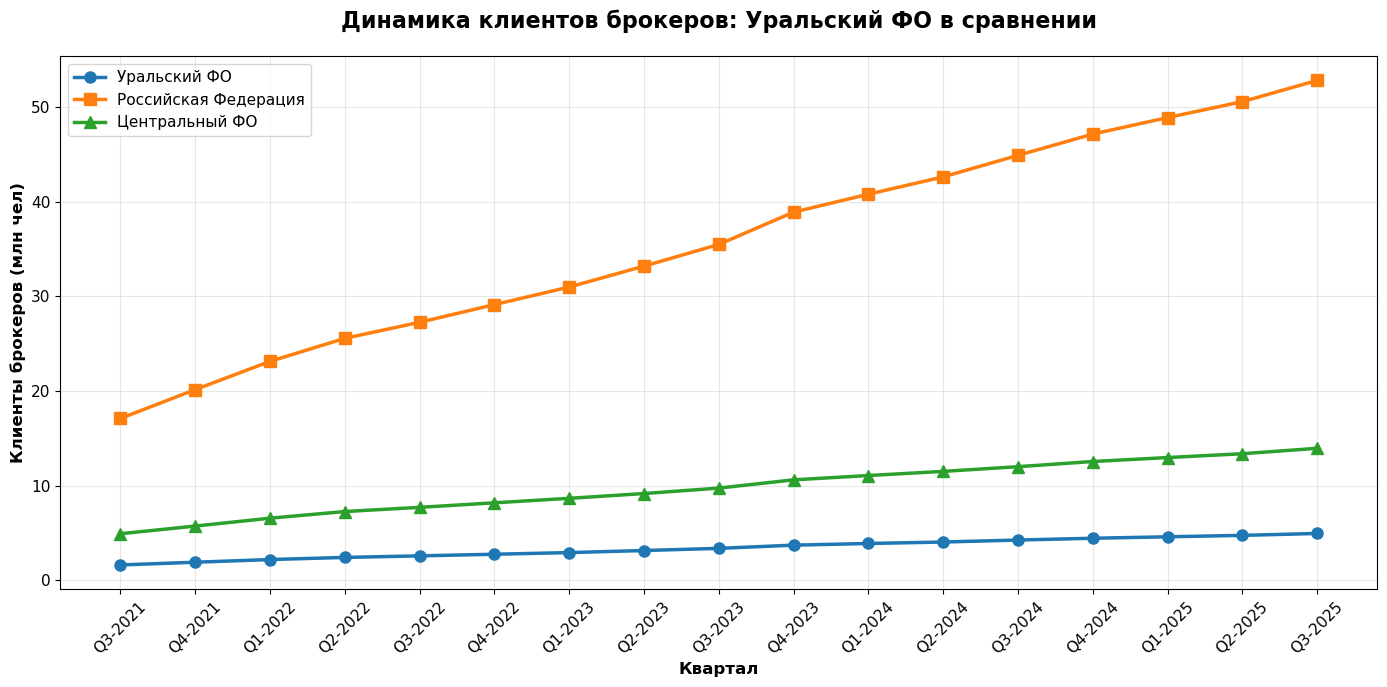

   ✅ Сохранен: 1_динамика_клиентов.png

📊 2. Сравнение регионов УрФО...
   Последний квартал: Q3-2025


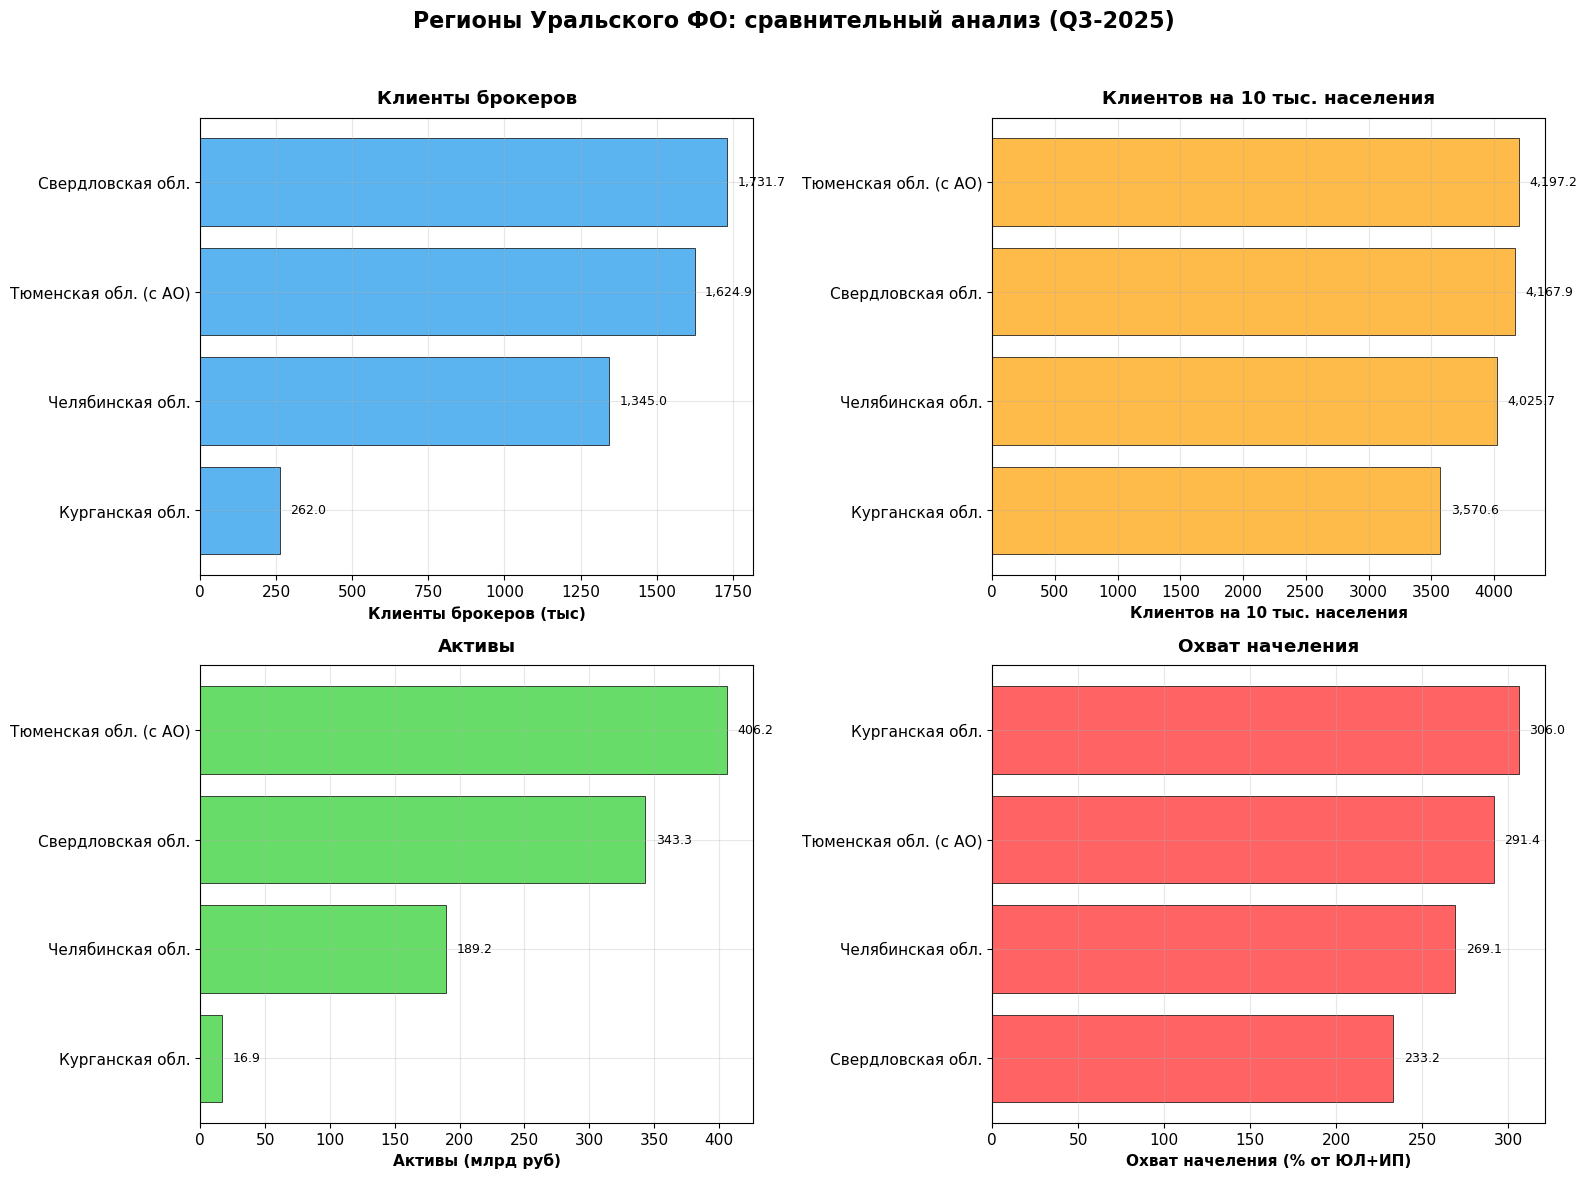

   ✅ Сохранен: 2_сравнение_регионов_урфо.png

📊 3. Сравнение федеральных округов...


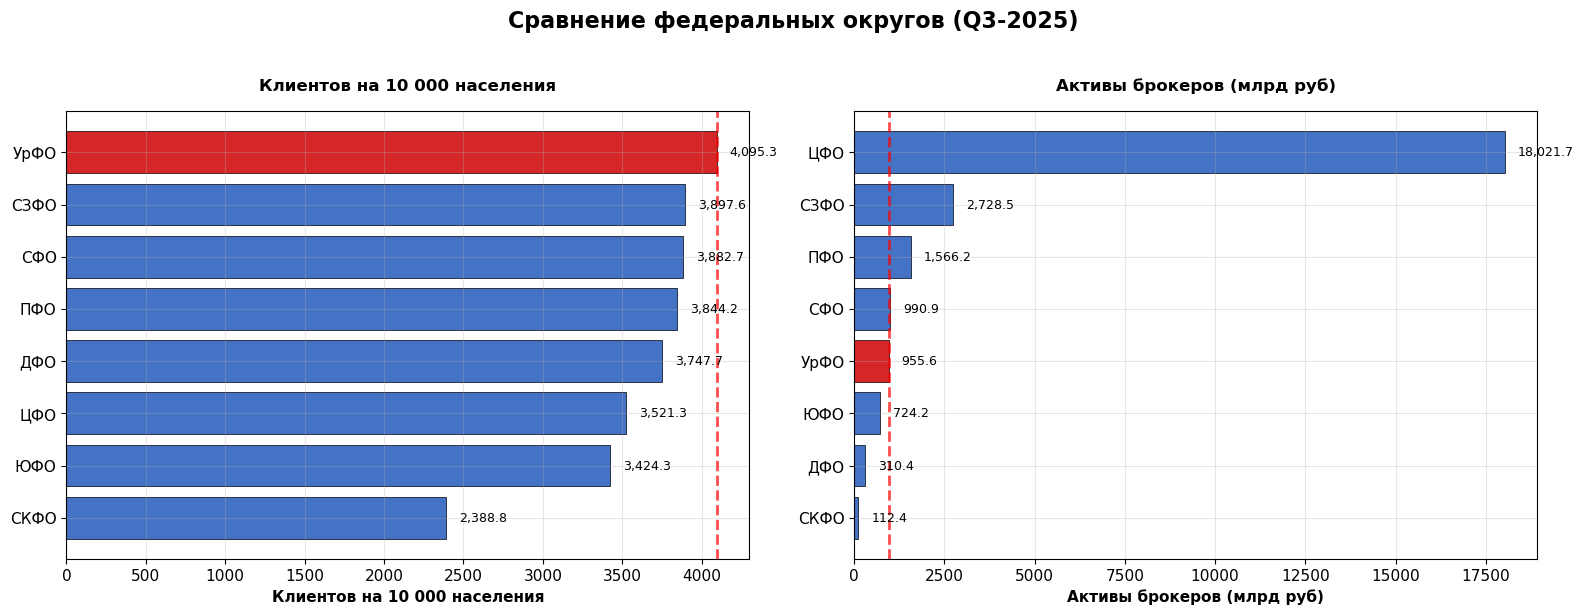

   ✅ Сохранен: 3_сравнение_фо.png

📊 4. Доля доверительного управления в УрФО...


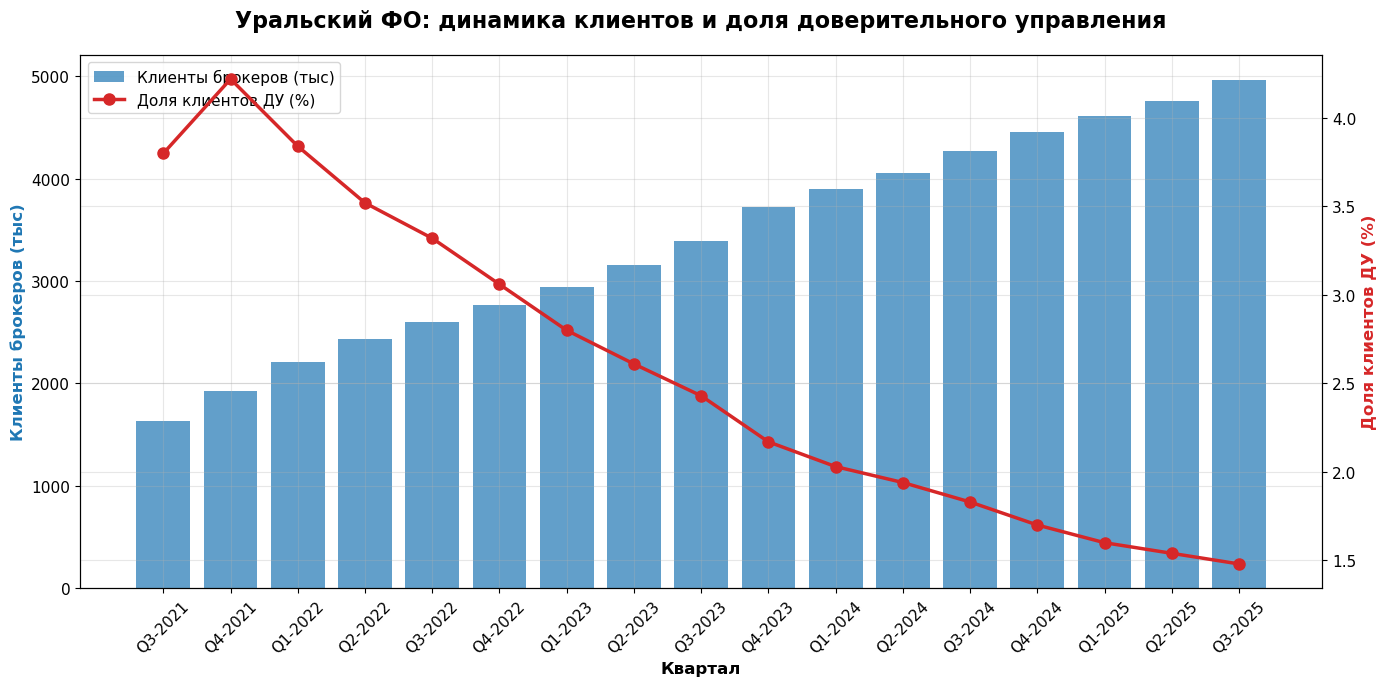

   ✅ Сохранен: 4_доля_ду_урфо.png

📊 5. Тепловая карта активов на душу населения...


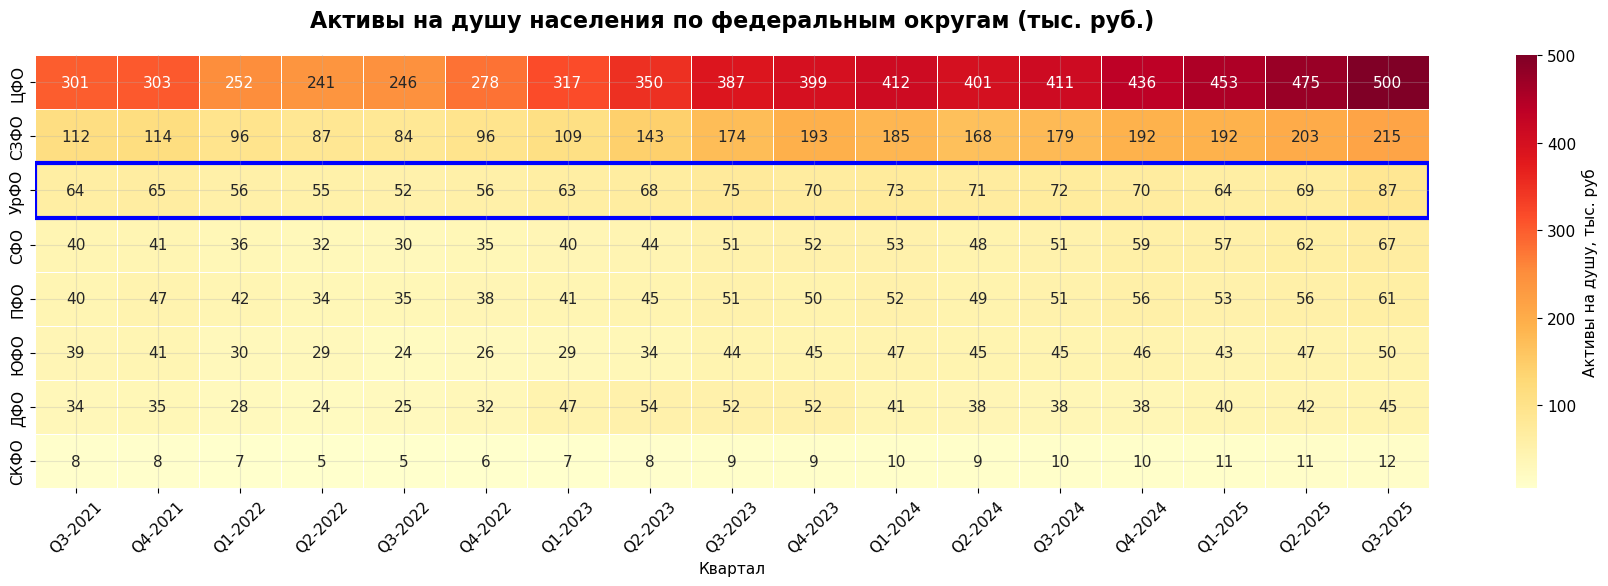

   ✅ Сохранен: 5_тепловая_карта.png

📊 ИТОГОВАЯ СТАТИСТИКА ПО ГРАФИКАМ

📁 Графики сохранены в папку: C:\Users\UwU\Desktop\ПУРЦБ_данные\результаты\ГРАФИКИ

📋 Список созданных графиков:
   1. 1_динамика_клиентов.png - Динамика клиентов брокеров
   2. 2_сравнение_регионов_урфо.png - Сравнение регионов УрФО
   3. 3_сравнение_фо.png - Сравнение федеральных округов
   4. 4_доля_ду_урфо.png - Доля доверительного управления в УрФО
   5. 5_тепловая_карта.png - Тепловая карта активов на душу населения

🎉 ВСЕ ГРАФИКИ УСПЕШНО СОЗДАНЫ!


In [9]:
# ============================================
# БЛОК 8: ВИЗУАЛИЗАЦИЯ
# ============================================

print("\n" + "="*60)
print("📈 БЛОК 8: Создание графиков для презентации")
print("="*60)

# Настройка стиля
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['font.size'] = 11

# ============================================
# 8.1 Функция для сортировки кварталов
# ============================================

def sort_quarters(quarters):
    """Сортирует кварталы в хронологическом порядке Q1-2021, Q2-2021, ..."""
    def q_key(q):
        year = int(q.split('-')[1])
        q_num = int(q[1])
        return (year, q_num)
    return sorted(quarters, key=q_key)

sorted_quarters_list = sort_quarters(df_final['Квартал'].unique())
print(f"\n📅 Кварталы отсортированы (первые 5): {sorted_quarters_list[:5]}")

# ============================================
# 8.2 ГРАФИК 1: Динамика клиентов брокеров
# ============================================

print("\n📊 1. Динамика клиентов брокеров (УрФО vs РФ vs ЦФО)...")

fig, ax = plt.subplots(figsize=(14, 7))

# Регионы для сравнения
plot_regions = [
    ('УРАЛЬСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ', '#1f77b4', 'o', 'Уральский ФО'),
    ('РОССИЙСКАЯ ФЕДЕРАЦИЯ', '#ff7f0e', 's', 'Российская Федерация'),
    ('ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ', '#2ca02c', '^', 'Центральный ФО')
]

for region, color, marker, label in plot_regions:
    region_data = df_final[df_final['Регион'] == region].copy()
    # Сортируем по кварталам
    region_data = region_data.set_index('Квартал').reindex(sorted_quarters_list).reset_index()
    region_data = region_data[region_data['Клиенты_брокеры'].notna()]
    
    if not region_data.empty:
        ax.plot(region_data['Квартал'], region_data['Клиенты_брокеры']/1e6, 
                marker=marker, linewidth=2.5, markersize=8, 
                label=label, color=color)

ax.set_xlabel('Квартал', fontsize=12, fontweight='bold')
ax.set_ylabel('Клиенты брокеров (млн чел)', fontsize=12, fontweight='bold')
ax.set_title('Динамика клиентов брокеров: Уральский ФО в сравнении', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=11)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(GRAPH_FOLDER, '1_динамика_клиентов.png'), 
            dpi=150, bbox_inches='tight')
plt.show()
print("   ✅ Сохранен: 1_динамика_клиентов.png")

# ============================================
# 8.3 ГРАФИК 2: Сравнение регионов УрФО (последний квартал)
# ============================================

print("\n📊 2. Сравнение регионов УрФО...")

# Определяем последний квартал
last_q = sorted_quarters_list[-1]
print(f"   Последний квартал: {last_q}")

# Регионы УрФО для сравнения
urfo_regions_plot = {
    'Свердловская область': 'Свердловская обл.',
    'Челябинская область': 'Челябинская обл.',
    'Курганская область': 'Курганская обл.',
    'Тюменская область, в т.ч. Ханты-Мансийский автономный округ - Югра, Ямало-Ненецкий автономный округ': 'Тюменская обл. (с АО)'
}

# Данные за последний квартал
urfo_last = df_final[df_final['Квартал'] == last_q].copy()
urfo_last = urfo_last[urfo_last['Регион'].isin(urfo_regions_plot.keys())].copy()
urfo_last['Регион_кратко'] = urfo_last['Регион'].map(urfo_regions_plot)

# Метрики для сравнения
metrics = [
    ('Клиенты_брокеры', 'Клиенты брокеров (тыс)', lambda x: x/1000),
    ('клиентов_на_10000_населения', 'Клиентов на 10 тыс. населения', lambda x: x),
    ('активы_млрд_руб', 'Активы (млрд руб)', lambda x: x),
    ('охват_населения_pct', 'Охват начеления (% от ЮЛ+ИП)', lambda x: x)
]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Регионы Уральского ФО: сравнительный анализ ({last_q})', 
             fontsize=16, fontweight='bold', y=0.98)

colors_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, (metric, title, transform) in enumerate(metrics):
    ax = axes[idx//2, idx%2]
    
    # Сортируем по убыванию
    data = urfo_last.sort_values(metric, ascending=True)
    
    # Цвета: УрФО выделяем основным цветом, остальные светлее
    base_color = colors_list[idx]
    colors = []
    for region in data['Регион_кратко']:
        if region == 'Уральский ФО (всего)':
            colors.append(base_color)
        else:
            # Делаем цвет светлее
            r = int(base_color[1:3], 16)
            g = int(base_color[3:5], 16)
            b = int(base_color[5:7], 16)
            lighter = f'#{min(255, r+60):02x}{min(255, g+60):02x}{min(255, b+60):02x}'
            colors.append(lighter)
    
    bars = ax.barh(data['Регион_кратко'], data[metric].apply(transform), 
                   color=colors, edgecolor='black', linewidth=0.5)
    
    # Добавляем значения на график
    for bar, val in zip(bars, data[metric].apply(transform)):
        ax.text(val + (max(data[metric].apply(transform))*0.02), 
                bar.get_y() + bar.get_height()/2, 
                f'{val:,.1f}', va='center', fontsize=9)
    
    ax.set_xlabel(title, fontweight='bold')
    ax.set_title(title.split(' (')[0], fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(GRAPH_FOLDER, '2_сравнение_регионов_урфо.png'), 
            dpi=150, bbox_inches='tight')
plt.show()
print("   ✅ Сохранен: 2_сравнение_регионов_урфо.png")

# ============================================
# 8.4 ГРАФИК 3: Сравнение федеральных округов
# ============================================

print("\n📊 3. Сравнение федеральных округов...")

# Список ФО
fo_list = [
    'ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'СИБИРСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'ЮЖНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'СЕВЕРО-ЗАПАДНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'УРАЛЬСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'ДАЛЬНЕВОСТОЧНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ',
    'СЕВЕРО-КАВКАЗСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ'
]

# Короткие названия для подписей
fo_names_short = {
    'ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ': 'ЦФО',
    'ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ': 'ПФО',
    'СИБИРСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ': 'СФО',
    'ЮЖНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ': 'ЮФО',
    'СЕВЕРО-ЗАПАДНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ': 'СЗФО',
    'УРАЛЬСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ': 'УрФО',
    'ДАЛЬНЕВОСТОЧНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ': 'ДФО',
    'СЕВЕРО-КАВКАЗСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ': 'СКФО'
}

# Данные за последний квартал
fo_last = df_final[(df_final['Регион'].isin(fo_list)) & 
                   (df_final['Квартал'] == last_q)].copy()
fo_last['ФО_кратко'] = fo_last['Регион'].map(fo_names_short)

# Две метрики для сравнения
metrics_fo = [
    ('клиентов_на_10000_населения', 'Клиентов на 10 000 населения', lambda x: x),
    ('активы_млрд_руб', 'Активы брокеров (млрд руб)', lambda x: x)
]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'Сравнение федеральных округов ({last_q})', 
             fontsize=16, fontweight='bold', y=1.02)

for idx, (metric, title, transform) in enumerate(metrics_fo):
    ax = axes[idx]
    data = fo_last.sort_values(metric, ascending=True)
    
    # Цвет: УрФО выделяем красным
    colors = ['#d62728' if x == 'УрФО' else '#4472C4' for x in data['ФО_кратко']]
    
    bars = ax.barh(data['ФО_кратко'], data[metric].apply(transform), 
                   color=colors, edgecolor='black', linewidth=0.5)
    
    # Добавляем значения
    for bar, val in zip(bars, data[metric].apply(transform)):
        ax.text(val + (max(data[metric].apply(transform))*0.02), 
                bar.get_y() + bar.get_height()/2, 
                f'{val:,.1f}', va='center', fontsize=9)
    
    ax.set_xlabel(title, fontweight='bold', fontsize=11)
    ax.set_title(title, fontweight='bold', pad=15, fontsize=12)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Вертикальная линия для УрФО
    urfo_val = data[data['ФО_кратко'] == 'УрФО'][metric].apply(transform).values[0]
    ax.axvline(x=urfo_val, color='red', linestyle='--', alpha=0.7, linewidth=2)

plt.tight_layout()
plt.savefig(os.path.join(GRAPH_FOLDER, '3_сравнение_фо.png'), 
            dpi=150, bbox_inches='tight')
plt.show()
print("   ✅ Сохранен: 3_сравнение_фо.png")

# ============================================
# 8.5 ГРАФИК 4: Доля ДУ в УрФО
# ============================================

print("\n📊 4. Доля доверительного управления в УрФО...")

# Данные по УрФО
urfo_dynamic = df_final[df_final['Регион'] == 'УРАЛЬСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ'].copy()
urfo_dynamic = urfo_dynamic.set_index('Квартал').reindex(sorted_quarters_list).reset_index()
urfo_dynamic = urfo_dynamic[urfo_dynamic['Клиенты_брокеры'].notna()]

fig, ax1 = plt.subplots(figsize=(14, 7))

# Столбцы - общее количество клиентов
ax1.bar(urfo_dynamic['Квартал'], urfo_dynamic['Клиенты_брокеры']/1e3, 
        color='#1f77b4', alpha=0.7, label='Клиенты брокеров (тыс)')

# Линия - доля ДУ
ax2 = ax1.twinx()
ax2.plot(urfo_dynamic['Квартал'], urfo_dynamic['доля_ду_в_клиентах_pct'], 
         color='#d62728', marker='o', linewidth=2.5, markersize=8,
         label='Доля клиентов ДУ (%)')

ax1.set_xlabel('Квартал', fontsize=12, fontweight='bold')
ax1.set_ylabel('Клиенты брокеров (тыс)', color='#1f77b4', fontsize=12, fontweight='bold')
ax2.set_ylabel('Доля клиентов ДУ (%)', color='#d62728', fontsize=12, fontweight='bold')
ax1.set_title('Уральский ФО: динамика клиентов и доля доверительного управления', 
              fontsize=16, fontweight='bold', pad=20)
ax1.tick_params(axis='x', rotation=45)

# Объединенная легенда
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11)

ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(GRAPH_FOLDER, '4_доля_ду_урфо.png'), 
            dpi=150, bbox_inches='tight')
plt.show()
print("   ✅ Сохранен: 4_доля_ду_урфо.png")

# ============================================
# 8.6 ГРАФИК 5: Тепловая карта активов на душу населения
# ============================================

print("\n📊 5. Тепловая карта активов на душу населения...")

# Сводная таблица для всех ФО
df_fo_all = df_final[df_final['Регион'].isin(fo_list)].copy()
pivot = df_fo_all.pivot_table(
    values='активов_на_душу_руб', 
    index='Регион', 
    columns='Квартал', 
    aggfunc='first'
)

# Сортируем колонки и строки
pivot = pivot.reindex(columns=sorted_quarters_list)
pivot.index = [fo_names_short.get(idx, idx) for idx in pivot.index]

# Сортируем строки по значению в последнем квартале
pivot = pivot.sort_values(by=last_q, ascending=False)

fig, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(pivot/1000, annot=True, fmt='.0f', cmap='YlOrRd',
            cbar_kws={'label': 'Активы на душу, тыс. руб'},
            linewidths=0.5, ax=ax)

# Выделяем УрФО
for i, idx in enumerate(pivot.index):
    if idx == 'УрФО':
        ax.add_patch(plt.Rectangle((0, i), len(pivot.columns), 1, 
                                   fill=False, edgecolor='blue', lw=3))
        break

ax.set_title('Активы на душу населения по федеральным округам (тыс. руб.)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Квартал')
ax.set_ylabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(GRAPH_FOLDER, '5_тепловая_карта.png'), 
            dpi=150, bbox_inches='tight')
plt.show()
print("   ✅ Сохранен: 5_тепловая_карта.png")

# ============================================
# 8.7 Итоговая статистика по графикам
# ============================================

print("\n" + "="*60)
print("📊 ИТОГОВАЯ СТАТИСТИКА ПО ГРАФИКАМ")
print("="*60)
print(f"\n📁 Графики сохранены в папку: {GRAPH_FOLDER}")
print("\n📋 Список созданных графиков:")
print("   1. 1_динамика_клиентов.png - Динамика клиентов брокеров")
print("   2. 2_сравнение_регионов_урфо.png - Сравнение регионов УрФО")
print("   3. 3_сравнение_фо.png - Сравнение федеральных округов")
print("   4. 4_доля_ду_урфо.png - Доля доверительного управления в УрФО")
print("   5. 5_тепловая_карта.png - Тепловая карта активов на душу населения")

print("\n" + "="*60)
print("🎉 ВСЕ ГРАФИКИ УСПЕШНО СОЗДАНЫ!")
print("="*60)